Mean: 0.5260897924453078
Variance: 1.1358721510555363


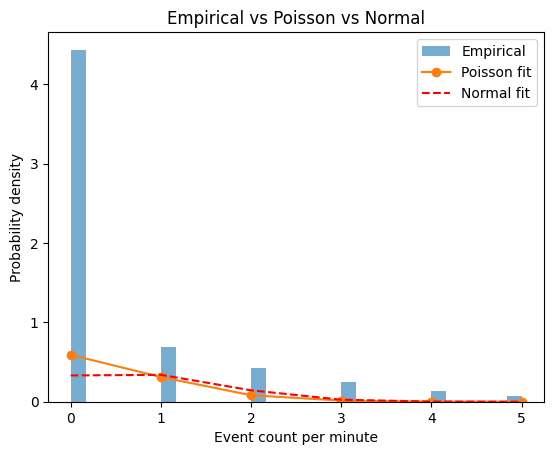

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1.4901161193847656e-08, but the percent differences are:
1.8799346707298126e-05

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# ---------------------------
# LOAD YOUR DATA
# ---------------------------

# Example: ransomware-like file access counts per minute
# Replace with your extracted per_window values
data = pd.read_csv("../data/file.csv")
data['date'] = pd.to_datetime(data['date'])

# Count file accesses per minute
counts = (
    data
    .set_index('date')
    .resample('1min')
    .size()
)

# Remove zero-heavy tail if desired (optional)
counts = counts[counts < counts.quantile(0.99)]

# Convert to numpy array
counts = counts.values.astype(int)

print("Mean:", counts.mean())
print("Variance:", counts.var())

# ---------------------------
# 1️⃣ VISUAL COMPARISON
# ---------------------------

plt.figure()
plt.hist(counts, bins=30, density=True, alpha=0.6, label="Empirical")

# Poisson fit
lambda_hat = counts.mean()
x = np.arange(0, counts.max()+1)
plt.plot(x, stats.poisson.pmf(x, lambda_hat), 'o-', label="Poisson fit")

# Normal fit
mu, sigma = counts.mean(), counts.std()
plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r--', label="Normal fit")

plt.legend()
plt.title("Empirical vs Poisson vs Normal")
plt.xlabel("Event count per minute")
plt.ylabel("Probability density")
plt.show()

# ---------------------------
# 2️⃣ CHI-SQUARE TEST (Poisson)
# ---------------------------

# Observed frequencies
obs_counts = np.bincount(counts)

# Expected frequencies under Poisson
expected_probs = stats.poisson.pmf(np.arange(len(obs_counts)), lambda_hat)
expected_counts = expected_probs * len(counts)

# Remove bins with low expected frequency (<5)
mask = expected_counts >= 5
chi2_stat, chi2_p = stats.chisquare(
    obs_counts[mask],
    expected_counts[mask]
)

print("\nChi-square test (Poisson):")
print("Chi-square statistic:", chi2_stat)
print("p-value:", chi2_p)

# ---------------------------
# 3️⃣ KS TEST (Poisson vs Normal)
# ---------------------------

# KS test expects continuous distributions
# We compare CDFs

poisson_cdf = stats.poisson.cdf(counts, lambda_hat)
normal_cdf = stats.norm.cdf(counts, mu, sigma)

ks_poisson = stats.kstest(counts, lambda x: stats.poisson.cdf(x, lambda_hat))
ks_normal = stats.kstest(counts, lambda x: stats.norm.cdf(x, mu, sigma))

print("\nKolmogorov–Smirnov test:")
print("Poisson KS statistic:", ks_poisson.statistic, "p-value:", ks_poisson.pvalue)
print("Normal KS statistic:", ks_normal.statistic, "p-value:", ks_normal.pvalue)
